# Use of Fatal Force by the US Police

Co-authored by Chun Sang Au Yong and Paavankumar Avasatthi. Paav is responsible for Exploratory Data Analysis, while Chun Sang is responsible for the rest.

## Introduction
In the United States, use of deadly force by police has been a high-profile and contentious issue. 1000 people are shot and killed by US cops each year. The ever-growing argument is that the US has a flawed Law Enforcement system that costs too many innocent civilians their lives. In this project, we will analyze one of America’s hottest political topics, which encompasses issues ranging from institutional racism to the role of Law Enforcement personnel in society.

We will use 5 data sets in this study. Four of them describes demographics of cities in the US (city data sets) while the remaining one records the fatal incidents (police data set).

In [168]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import pickle

from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential

## Data Preprocessing

In [169]:
education = pd.read_csv('data/education.csv', encoding = "ISO-8859-1")
income = pd.read_csv('data/income.csv', encoding = "ISO-8859-1")
poverty = pd.read_csv('data/poverty.csv', encoding = "ISO-8859-1")
race = pd.read_csv('data/share_race_by_city.csv', encoding = "ISO-8859-1")
test = pd.read_csv('data/police_killings_test.csv', encoding = "ISO-8859-1")
train = pd.read_csv('data/police_killings_train.csv', encoding = "ISO-8859-1")

We first inspect and clean null data.

In [170]:
train.isnull().sum()

id                          0
name                        0
date                        0
manner_of_death             0
armed                       6
age                        37
gender                      0
race                       91
city                        0
state                       0
signs_of_mental_illness     0
threat_level                0
flee                       27
body_camera                 0
dtype: int64

In [171]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [172]:
train = clean_dataset(train)
test = clean_dataset(test)

### Merging Counts to City Data Sets

By merging the count of fatal incident grouped by city to the city data sets, we can perform linear regression using demographics as independent variables and count as a depedent variable.

There is a discrepancy between the encoding of names between the police data set and city data sets. For example, the former refer LA in California as Los Angeles while the latter uses Los Angeles city.

We also observe that the police data set provide less information because it only has Chicago as a city, while the city data sets have Chicago city, Chicago Heights city and Chicago Ridge village. Assuming that cities bearing similar name should be geographically and demographically close to each other, we shall evenly distribute the number of fatal incidents between them.

In [173]:
# count the number of incidents grouping by city and state because city names may duplicate
df = pd.concat([train, test], ignore_index=True)
city_count = df.value_counts(['city', 'state']).rename_axis(['City', 'Geographic Area']).reset_index(name='Counts')
city_count.head()

,City,Geographic Area,Counts
0,Los Angeles,CA,35
1,Phoenix,AZ,28
2,Houston,TX,23
3,Chicago,IL,22
4,Las Vegas,NV,17


In [174]:
city = education.merge(income, on=['Geographic Area', 'City']).merge(poverty, on=['Geographic Area', 'City']).merge(race, on=['Geographic Area', 'City'])
city.head()

,Geographic Area,City,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AL,Abanda CDP,21.2,11207,78.8,67.2,30.2,0,0,1.6
1,AL,Abbeville city,69.1,25615,29.1,54.4,41.4,0.1,1,3.1
2,AL,Adamsville city,78.9,42575,25.5,52.3,44.9,0.5,0.3,2.3
3,AL,Addison town,81.4,37083,30.7,99.1,0.1,0,0.1,0.4
4,AL,Akron town,68.6,21667,42,13.2,86.5,0,0,0.3


In [175]:
def merge_count(record):
    # find record(s) matching both name and state
    match_city = city_total['City'].str.startswith(record['City'])
    match_state = city_total['Geographic Area'] == record['Geographic Area']
    match_both = np.logical_and(match_city, match_state)
    # count the number of True
    length = np.count_nonzero(match_both)
    if length == 1:     # if unique
        city_total.loc[match_both, 'Counts'] = record['Counts']
    elif length > 1:    # if multiple, take average
        count = record['Counts']/length
        city_total.loc[match_both, 'Counts'] = count

city_total = city.copy()    # changes to city_total will not affect city
city_total['Counts'] = 0
city_count.apply(merge_count, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1377    None
1378    None
1379    None
1380    None
1381    None
Length: 1382, dtype: object

In [176]:
city_total.sort_values(by='Counts', ascending=False).head()

,Geographic Area,City,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,Counts
2701,CA,Los Angeles city,75.5,50205,22.1,49.8,9.6,0.7,11.3,48.5,35.0
1198,AZ,Phoenix city,80.7,47326,23.1,65.9,6.5,2.2,3.2,40.8,28.0
25036,TX,Houston city,76.7,46187,22.5,50.5,23.7,0.7,6,43.8,23.0
15596,NV,Las Vegas city,83.3,50202,17.5,62.1,11.1,0.7,6.1,31.5,17.0
24428,TX,Austin city,87.5,57689,18,68.3,8.1,0.9,6.3,35.1,16.0


### Merging City Data Sets to the Police Data Set

By merging the city demographics to the police data set, we can append background information to each of the incident. In this study, we will use various city demographics as independent variables to predict the race of victim.

In [177]:
fields = ['percent_completed_hs', 'Median Income', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']

def merge_city(record):
    # find record(s) matching both name and state
    match_city = city['City'].str.startswith(record['city'])
    match_state = city['Geographic Area'] == record['state']
    match_both = np.logical_and(match_city, match_state)
    match = city.loc[match_both]
    # assign the mean of city demographics to the police data set
    for field in fields:
        record.loc[field] = pd.to_numeric(match[field], errors='coerce').mean()
    return record[fields]

train[fields] = train.apply(merge_city, axis=1)
test[fields] = test.apply(merge_city, axis=1)

In [178]:
train.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,flee,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,...,Not fleeing,False,80.1,37072.0,28.6,78.9,0.8,3.7,1.1,19.2
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,...,Not fleeing,False,88.1,65765.0,14.9,70.9,2.6,1.0,8.9,21.1
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,Not fleeing,False,87.5,45947.0,17.3,71.9,11.5,1.2,4.8,15.3
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,...,Not fleeing,False,87.0,81294.0,13.2,48.5,6.1,0.5,33.3,15.1
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,...,Not fleeing,False,76.3,47791.0,16.6,76.5,0.9,1.2,0.9,43.1


Since some rows in the police data set do not have corresponding cities, they will have NaN values which needs to be cleaned.

In [179]:
train = clean_dataset(train)
test = clean_dataset(test)

In [180]:
train.to_csv('processed/train.csv', index=False)
test.to_csv('processed/test.csv', index=False)

## Exploratory Data Analysis

In [181]:
train.interpolate()
train.isnull().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
percent_completed_hs       0
Median Income              0
poverty_rate               0
share_white                0
share_black                0
share_native_american      0
share_asian                0
share_hispanic             0
dtype: int64

In [182]:
train.shape

(1697, 22)

In [183]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697 entries, 0 to 2027
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1697 non-null   int64  
 1   name                     1697 non-null   object 
 2   date                     1697 non-null   object 
 3   manner_of_death          1697 non-null   object 
 4   armed                    1697 non-null   object 
 5   age                      1697 non-null   float64
 6   gender                   1697 non-null   object 
 7   race                     1697 non-null   object 
 8   city                     1697 non-null   object 
 9   state                    1697 non-null   object 
 10  signs_of_mental_illness  1697 non-null   bool   
 11  threat_level             1697 non-null   object 
 12  flee                     1697 non-null   object 
 13  body_camera              1697 non-null   bool   
 14  percent_completed_hs    

In [184]:
train.describe()

,id,age,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
count,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000
mean,1149.212139,35.873306,84.316807,49455.544603,19.367568,67.292879,15.205275,1.432133,4.359952,20.627339
std,632.922020,12.483521,8.365033,16450.198560,8.087651,19.467030,17.309810,4.954118,6.374263,20.176668
min,3.000000,6.000000,33.150000,17438.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000
25%,617.000000,26.000000,80.700000,39681.000000,14.300000,52.700000,2.500000,0.300000,1.000000,5.133333
50%,1151.000000,34.000000,85.600000,46912.000000,19.000000,69.700000,8.400000,0.600000,2.400000,12.700000
75%,1688.000000,44.000000,89.800000,54618.000000,23.400000,82.500000,22.600000,1.000000,5.000000,32.700000
max,2260.000000,83.000000,100.000000,198839.000000,76.400000,100.000000,98.000000,95.000000,61.900000,97.800000


In [185]:
train.nunique()

id                         1697
name                       1693
date                        672
manner_of_death               2
armed                        56
age                          69
gender                        2
race                          6
city                        941
state                        51
signs_of_mental_illness       2
threat_level                  3
flee                          4
body_camera                   2
percent_completed_hs        362
Median Income               995
poverty_rate                381
share_white                 543
share_black                 409
share_native_american       114
share_asian                 199
share_hispanic              433
dtype: int64

We now investigate how the fatal police shootings vary based on the different geographic loactions. The train dataset has 51 unique values for state. These include Washington DC in addition to the 50 states within the United States. We can see that CA has the highest the count of all state values present in the train dataset. 

Text(0.5, 1.0, 'Number of incidents by city')

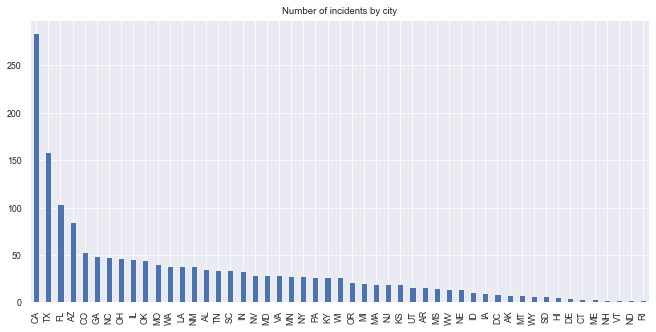

In [186]:
fig, ax = plt.subplots(figsize=(9, 4.5), layout='constrained')
train['state'].value_counts().plot(kind='bar')
ax.set_title("Number of incidents by city")

Next, we look at the cities in the dataset, to determine which city may be considered the most dangerous. There are 941 cities. Los Angeles has the highest count of all cities in our dataset, 31. The top 5 and the bottom five cities with the respect to the counts are shown. It makes sense for cities like Los Angeles, Pheonix, Huston, Chicago, and Las Vegas to have higher counts of incident reports in the dataset.

In [187]:
train['city'].value_counts()

Los Angeles    31
Phoenix        22
Houston        21
Chicago        19
Las Vegas      15
               ..
Chalmette       1
Lead            1
Dickson         1
Slidell         1
Kuna            1
Name: city, Length: 941, dtype: int64

In the training data, a gun is the most common way of being armed. The counts of other weapons used is given below.

In [188]:
armcount = train['armed'].value_counts()
print(armcount)

gun                                 931
knife                               250
unarmed                             134
vehicle                             107
toy weapon                           80
undetermined                         76
machete                              14
sword                                 8
unknown weapon                        6
box cutter                            5
ax                                    5
metal pipe                            5
Taser                                 5
hammer                                5
baseball bat                          4
screwdriver                           4
gun and knife                         4
hatchet                               4
scissors                              3
guns and explosives                   3
blunt object                          3
rock                                  2
meat cleaver                          2
shovel                                2
metal stick                           2


We also plot the top 6 common weapons in the data set.

Text(0.5, 1.0, 'Relative proportion of weapons')

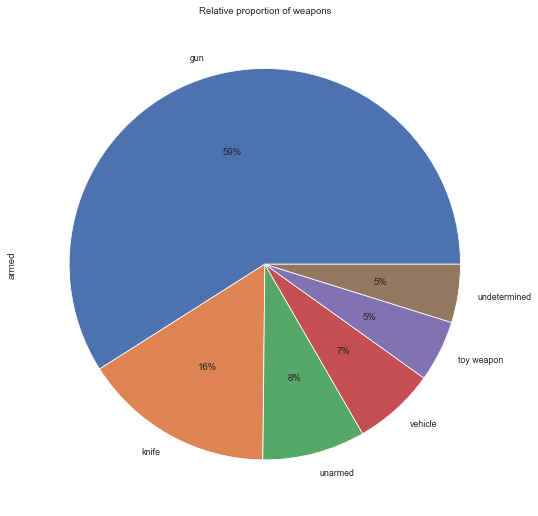

In [189]:
fig, ax = plt.subplots(figsize=(9, 9))
armcount.head(6).plot(kind='pie', autopct='%.0f%%')
ax.set_title("Relative proportion of weapons")

We plot the columns to study the distribution of features.

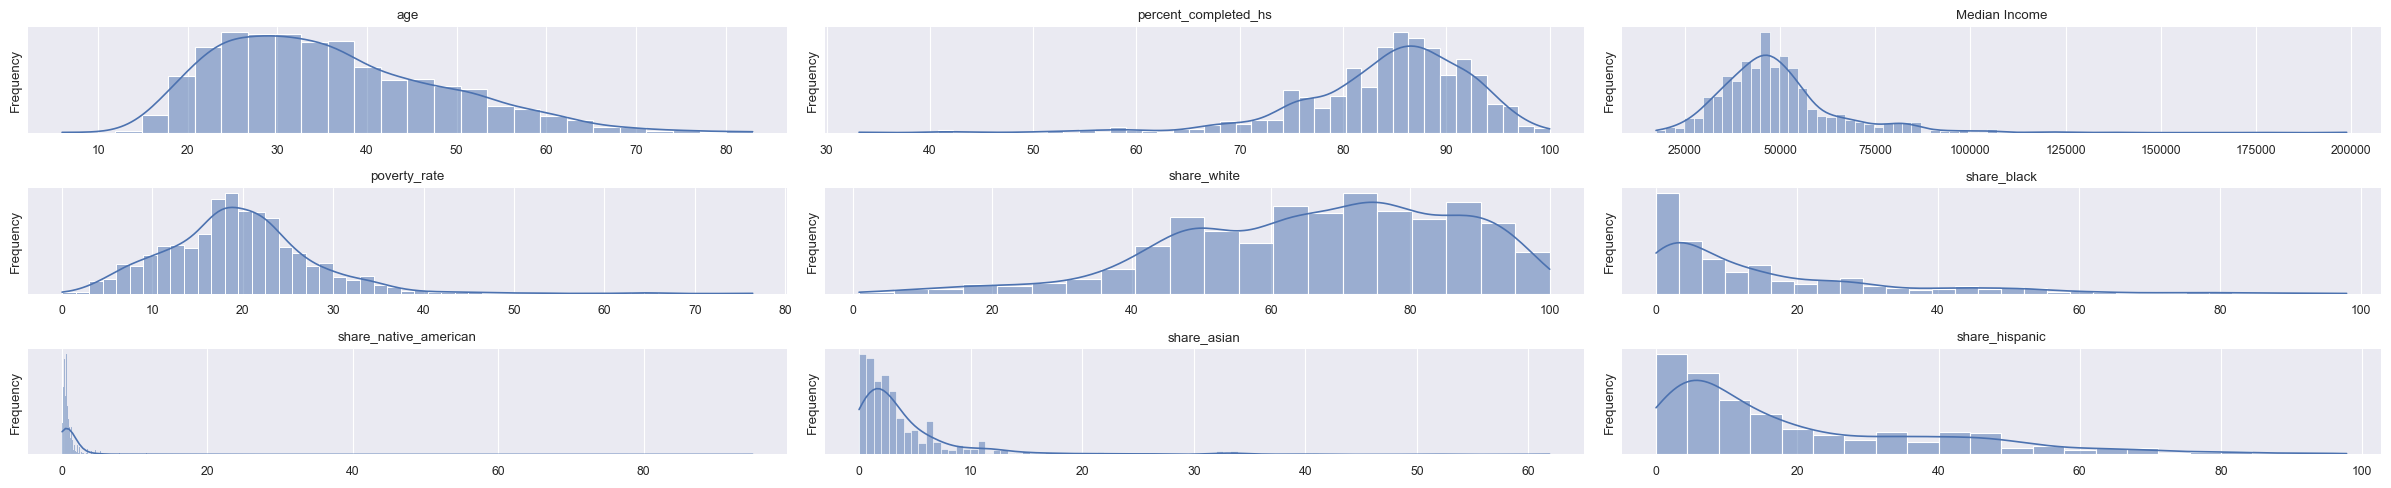

In [190]:
columns = ['age', 'percent_completed_hs', 'Median Income', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']
fig = plt.figure(dpi=100, figsize=(24, 16), tight_layout=True)
sns.set_theme()
sns.set_context("paper")
for i, col in enumerate(columns):
  ax = fig.add_subplot(10, 3, i + 1)
  sns.histplot(train[col], kde=True)
  ax.set_title(col)
  ax.set_yticks([])
  ax.set_ylabel("Frequency")
  ax.set_xlabel(None)
  ax.tick_params(left=False, bottom=False)
  for ax, spine in ax.spines.items():
    spine.set_visible(False)

For the race of victim, we first plot the aggregate proportion and then their age distribution.

Text(0.5, 1.0, 'Proportion of race of victims')

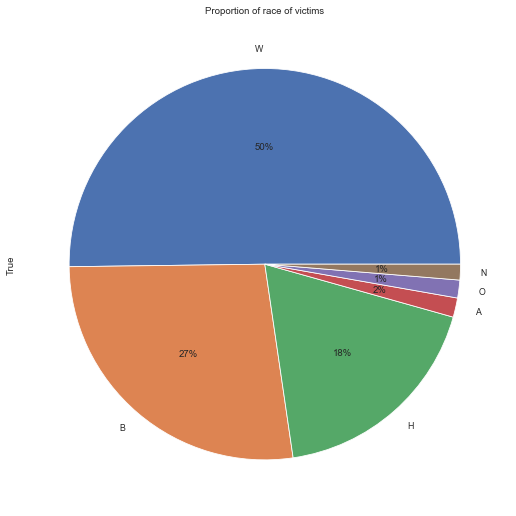

In [191]:
fig, ax = plt.subplots(figsize=(9, 9))
train['race'].value_counts().plot(kind='pie', ax=ax, label=True, autopct='%.0f%%')
ax.set_title("Proportion of race of victims")

In [192]:
test['race'].value_counts()

W    158
B     96
H     64
A      6
N      3
Name: race, dtype: int64

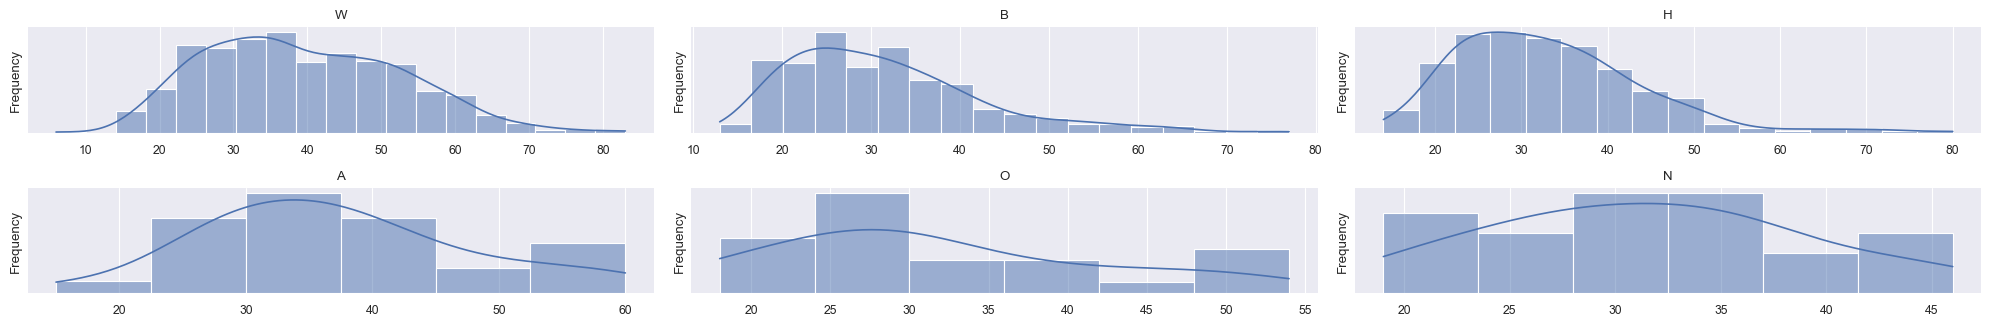

In [193]:
columns = train['race'].value_counts().keys()
fig = plt.figure(dpi=100, figsize=(20, 16), tight_layout=True)
sns.set_theme()
sns.set_context("paper")
for i, col in enumerate(columns):
  ax = fig.add_subplot(10, 3, i + 1)
  sns.histplot(train.query('race == "'+col+'"')['age'], kde=True)
  ax.set_title(col)
  ax.set_yticks([])
  ax.set_ylabel("Frequency")
  ax.set_xlabel(None)
  ax.tick_params(left=False, bottom=False)
  for ax, spine in ax.spines.items():
    spine.set_visible(False)

We visualise the correlation of columns with a heatmap.

<AxesSubplot:>

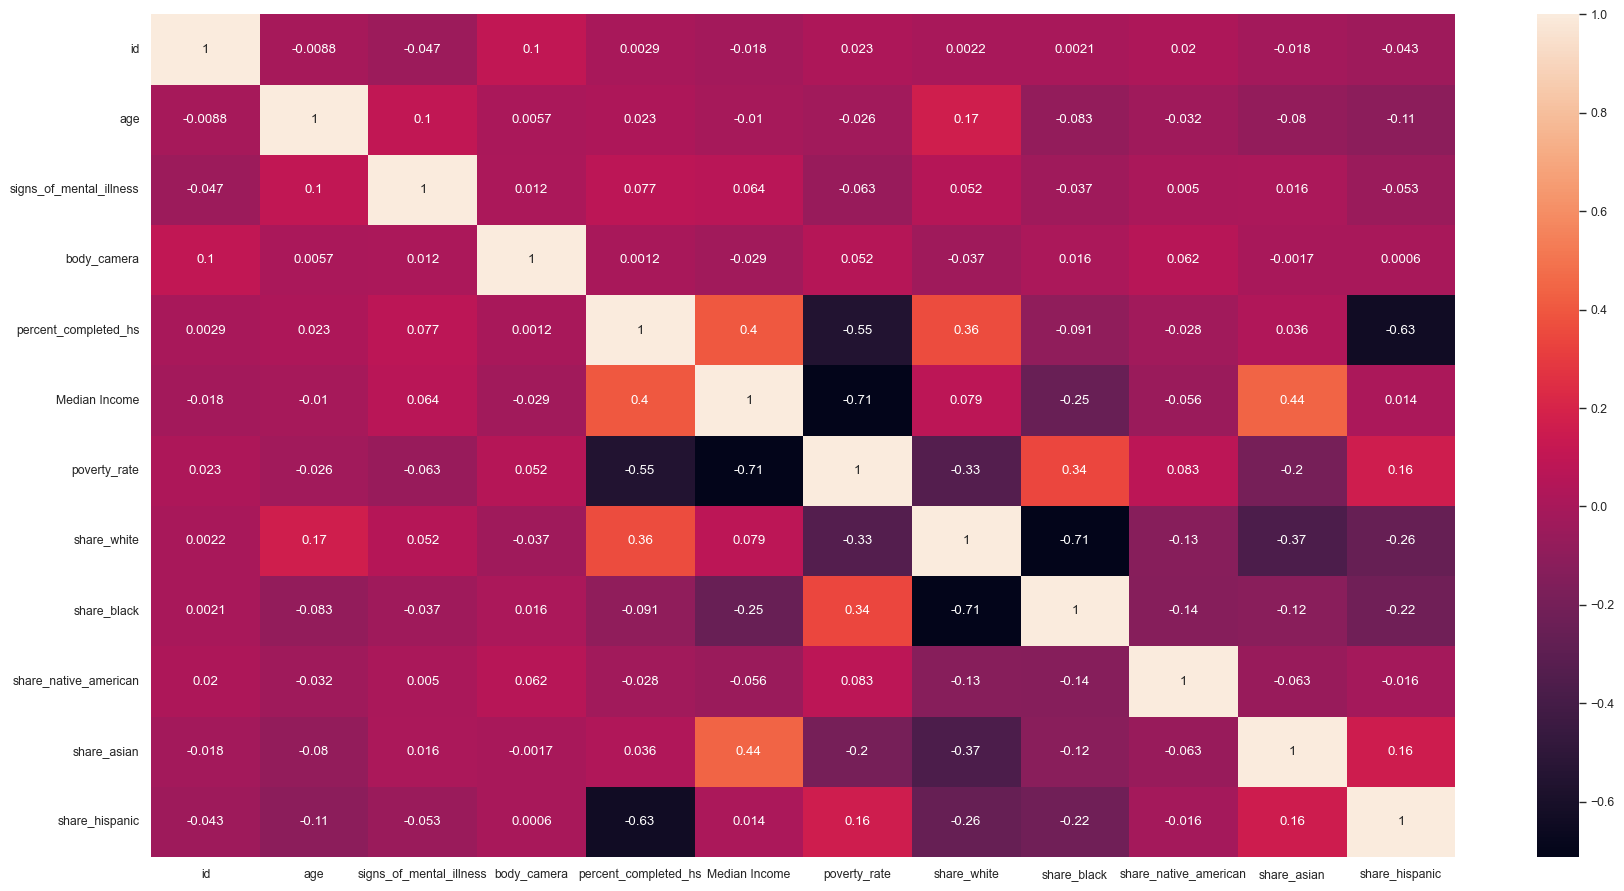

In [194]:
fig = plt.figure(dpi=100, figsize=(18, 9), tight_layout=True)
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

## Recoding Features

There are too many unique values for the column armed. Since we only study whether the victim is armed or not, we can convert all values other than 'unarmed' and 'undetermined' to 'armed'.

In [195]:
train['armed'].value_counts()

gun                                 931
knife                               250
unarmed                             134
vehicle                             107
toy weapon                           80
undetermined                         76
machete                              14
sword                                 8
unknown weapon                        6
box cutter                            5
ax                                    5
metal pipe                            5
Taser                                 5
hammer                                5
baseball bat                          4
screwdriver                           4
gun and knife                         4
hatchet                               4
scissors                              3
guns and explosives                   3
blunt object                          3
rock                                  2
meat cleaver                          2
shovel                                2
metal stick                           2


In [196]:
train['armed'].where(np.logical_or(train['armed'] == 'unarmed', train['armed'] == 'undetermined'), 'armed', inplace=True)
test['armed'].where(np.logical_or(test['armed'] == 'unarmed', test['armed'] == 'undetermined'), 'armed', inplace=True)
train['armed'].value_counts()

armed           1487
unarmed          134
undetermined      76
Name: armed, dtype: int64

To make the features interpretable to the classifier, we create dummy columns for categorical varialbes. We then proceed to separate the independent and the dependent variables in the data set, while also eliminate columns that are irrelevant to the study. We also eliminate city and state information because they are already represented by the parameters in the city data sets.

In [197]:
X_train = pd.get_dummies(train.drop(columns=['id', 'name', 'race', 'date', 'city', 'state']))
y_train = train['race']
X_test = pd.get_dummies(test.drop(columns=['id', 'name', 'race', 'date', 'city', 'state']))
y_test = test['race']

In [198]:
X_train.head()

,age,signs_of_mental_illness,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,...,armed_undetermined,gender_F,gender_M,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,53.0,True,False,80.1,37072.0,28.6,78.9,0.8,3.7,1.1,...,0,0,1,1,0,0,0,0,1,0
1,47.0,False,False,88.1,65765.0,14.9,70.9,2.6,1.0,8.9,...,0,0,1,1,0,0,0,0,1,0
2,23.0,False,False,87.5,45947.0,17.3,71.9,11.5,1.2,4.8,...,0,0,1,0,1,0,0,0,1,0
3,32.0,True,False,87.0,81294.0,13.2,48.5,6.1,0.5,33.3,...,0,0,1,1,0,0,0,0,1,0
4,39.0,False,False,76.3,47791.0,16.6,76.5,0.9,1.2,0.9,...,0,0,1,1,0,0,0,0,1,0


In [199]:
y_train.head()

0    A
1    W
2    H
3    W
4    H
Name: race, dtype: object

## Prediting Race of Victims

We now use a mixture of the features to predict the race of victims in fatal incidents.

### Logistic Regression

In [200]:
clf = LogisticRegression(max_iter=10000, multi_class='multinomial')
clf.fit(X_train, y_train)
with open('output/logreg.pkl','wb') as f:
    pickle.dump(clf,f)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

Train accuracy = 0.6670595167943429.
Test accuracy = 0.6391437308868502.


Cross validation is implemented to reduce overfitting.

In [201]:
clf = LogisticRegressionCV(max_iter=10000, multi_class='multinomial', cv=5)
clf.fit(X_train, y_train)
with open('output/logregCV.pkl','wb') as f:
    pickle.dump(clf,f)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

Train accuracy = 0.6588096641131408.
Test accuracy = 0.6422018348623854.


### Tree Classifier

Train accuracy = 0.6611667648791986.
Test accuracy = 0.599388379204893.


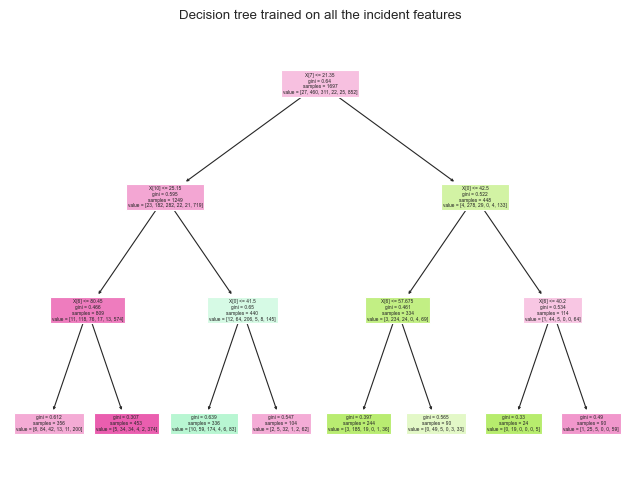

<Figure size 432x288 with 0 Axes>

In [202]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

plt.figure(figsize=(8, 6), dpi=100)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the incident features")
plt.show()
plt.savefig('output/incident_tree.png')

The large discrepancy between the accuracy of test and train data set respectively shows that the decision tree faces overfitting. We then turn to random forest to solve this problem by ensemble method.

In [203]:
clf = RandomForestClassifier(max_depth=10, class_weight='balanced_subsample')
clf.fit(X_train, y_train)
with open('output/randomforest.pkl','wb') as f:
    pickle.dump(clf,f)
print(f'Train accuracy = {clf.score(X_train, y_train)}.')
print(f'Test accuracy = {clf.score(X_test, y_test)}.')

Train accuracy = 0.8738951090159104.
Test accuracy = 0.6207951070336392.


## Predicting Count of Incidents

In this section, we would like to use the count of incidents by city as a dependent variable in regression to investigate what factors contribute to a high count.

In [204]:
zero_count = city_total.loc[city_total['Counts'] == 0].shape[0]
print(f'There are {zero_count} cities with no fatal incident.')
print(f'They account for {zero_count/city_total.shape[0]*100}% of all the cities.')

There are 27811 cities with no fatal incident.
They account for 95.52120899879787% of all the cities.


We remove cities without accidents from the data set so that a relationship between cities and counts can be better formulated. Otherwise, a dummy regressor which contantly outputs 0 would achieve a good MSE.

In [205]:
# drop city without accidents
city = city_total.loc[city_total['Counts'] != 0]
# drop city names and clean non-numerical data
city = city.drop(columns=['Geographic Area', 'City']).apply(pd.to_numeric, errors='coerce').dropna()
# scale columns
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(city.drop(columns='Counts')))
y = city['Counts']
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [206]:
X_train.head()

,0,1,2,3,4,5,6,7
1188,0.569728,0.086623,0.353955,0.324297,0.637755,0.003012,0.011309,0.045175
1242,0.755102,0.118957,0.237323,0.735944,0.234694,0.003012,0.008078,0.009240
627,0.744898,0.214771,0.177485,0.759036,0.154082,0.003012,0.042003,0.060575
148,0.666667,0.174545,0.245436,0.691767,0.064286,0.008032,0.058158,0.289528
217,0.955782,0.634324,0.054767,0.640562,0.019388,0.002008,0.437803,0.063655


### Linear Regression

The low R2 score for linear regression suggests that a linear relationship cannot be established between city features and counts. However, on the scale of 1 to 35 (the highest count), the mean absolute error is acceptable.

In [207]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f'Train R2 = {reg.score(X_train, y_train)}.')
print(f'Test R2 = {reg.score(X_test, y_test)}.')
print(f'Test MAE = {mean_absolute_error(y_test, reg.predict(X_test))}.')
print(f'Test MSE = {mean_squared_error(y_test, reg.predict(X_test))}.')

Train R2 = 0.051798563950877896.
Test R2 = 0.05204606689119606.
Test MAE = 0.9519223761546299.
Test MSE = 4.760611286961843.


### Neural Network

A neural network can model non-linear relationships between city features and counts.

In [208]:
model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 2670)              24030     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2671      
Total params: 26,773
Trainable params: 26,773
Non-trainable params: 0
_________________________________________________________________


In [209]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mse','mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

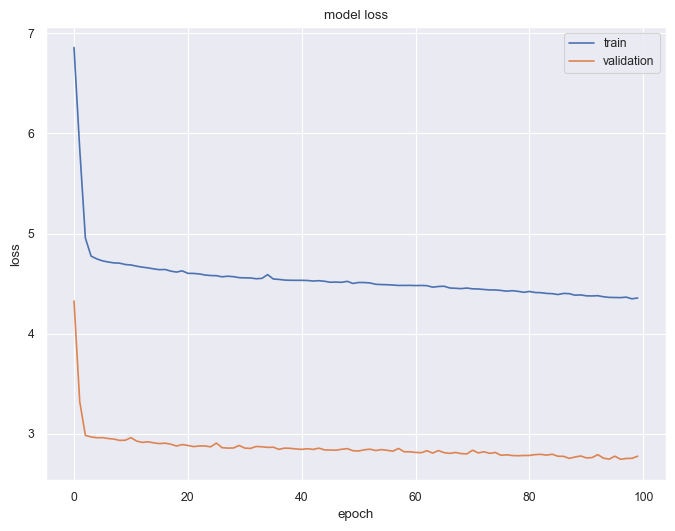

In [210]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [211]:
y_pred = model.predict(X_test)
print(f'Test MAE = {mean_absolute_error(y_test, y_pred)}.')
print(f'Test MSE = {mean_squared_error(y_test, y_pred)}.')

Test MAE = 0.9598979898768417.
Test MSE = 4.603765202153685.


Contrary to our belief, the neural network ended up performing similarly to the linear regression. 

## Conclusion

In this analysis, we successfully predicted the race of victims in a fatal incident. We also built models to predict the number of victims in a city given the aggregate statistics of a city. We hope that the relationship discovered can be used towards reducing future fatal incidents, such as funneling more resource into training and education of officers in incident-prone cities. 